In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [17]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(5)

# Setup your client
client = Client(cluster)

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40399 instead
  warnings.warn(


### Map to check

In [4]:
def plot_spatial_diagnostics(var_name, obs, default, tuned,
                              vmin=None, vmax=None, cmap='PRGn', savepath=None):

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.Robinson()})
    plt.rcParams['font.size'] = 16
    cropmask = xr.open_dataset(utils_path+'cropmask.nc')
    crop_mask = (cropmask.crop == 0)

    lf = xr.open_dataset(utils_path+'CLM-SP_amaxTLAI.nc').landfrac

    ## Panel 1: Observations
    ax = axes[0]
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    obs_data = obs * crop_mask.values
    pcm = ax.pcolormesh(obs.lon, obs.lat, obs_data, transform=ccrs.PlateCarree(),
                        shading='auto', cmap='Greens')
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var_name)
    ax.set_title('Observed')

    ## Panel 2: Default - Obs
    ax = axes[1]
    model_default = get_map(default) * lf
    diff = (model_default - obs) * crop_mask.values
    rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    pcm = ax.pcolormesh(obs.lon, obs.lat, diff, transform=ccrs.PlateCarree(),
                        shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var_name)
    ax.set_title(f'Default - Observed\nRMSE = {rmse}')

    ## Panel 3: Tuned - Obs
    ax = axes[2]
    model_tuned = get_map(tuned) * lf
    diff = (model_tuned - obs) * crop_mask.values
    rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    pcm = ax.pcolormesh(obs.lon, obs.lat, diff, transform=ccrs.PlateCarree(),
                        shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var_name)
    ax.set_title(f'Tuned - Observed\nRMSE = {rmse}')

    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=100)
    plt.show()


In [5]:
dvs = ['TOTVEGC','GPP','TLAI','EFLX_LH_TOT','ER','TOTSOMC_1m']

def pp(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds[dvs]

In [6]:
# Load default
path = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_lhc/hist/*lhc0000*.h0.*'
files=sorted(glob.glob(path))
ds_default = xr.open_mfdataset(files[28:],preprocess=pp).compute()
# calculate 
lai_default = amax(ds_default['TLAI']).sel(year=slice('2001','2020')).mean(dim='year')
gpp_default = amean(ds_default['GPP']).sel(year=slice('2001','2015')).mean(dim='year')
tvc_default = amean(ds_default['TOTVEGC']).sel(year=slice('2000','2019')).mean(dim='year')

/glade/derecho/scratch/linnia/tmp/ipykernel_19641/3498305289.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_default = xr.open_mfdataset(files[28:],preprocess=pp).compute()
/glade/derecho/scratch/linnia/tmp/ipykernel_19641/3498305289.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_default = xr.open_mfdataset(files[28:],preprocess=pp).compute()
/glade/derecho/scratch/linnia/tmp/ipykernel_19641/3498305289.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_default = xr.open_mfdataset(files[28:],preprocess=pp).compute(

In [7]:
# load test ensemble
base_path = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_'
ensemble_ids = [f"caltest{str(i).zfill(4)}" for i in range(103, 108)]

all_datasets = []

for ens_index, ens_id in enumerate(ensemble_ids):
    path = os.path.join(base_path + ens_id, 'run', '*.h0.*')
    files = sorted(glob.glob(path))
    
    if not files:
        print(f"No files found for ensemble {ens_id}")
        continue
    
    ds = xr.open_mfdataset(files[28:], preprocess=pp)
    ds = ds.expand_dims(ens=[ens_index])
    all_datasets.append(ds)

combined_ds = xr.concat(all_datasets, dim='ens')

# calculate 
lai = amax(combined_ds['TLAI']).sel(year=slice('2001','2020')).mean(dim='year')
gpp = amean(combined_ds['GPP']).sel(year=slice('2001','2015')).mean(dim='year')
tvc = amean(combined_ds['TOTVEGC']).sel(year=slice('2000','2019')).mean(dim='year')

No files found for ensemble caltest0103
No files found for ensemble caltest0104
No files found for ensemble caltest0105


/glade/derecho/scratch/linnia/tmp/ipykernel_19641/1203344492.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files[28:], preprocess=pp)
/glade/derecho/scratch/linnia/tmp/ipykernel_19641/1203344492.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files[28:], preprocess=pp)
/glade/derecho/scratch/linnia/tmp/ipykernel_19641/1203344492.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files[28:], preprocess=pp)
/glade/derecho/scratch/linnia/tmp/ipykernel_19

In [46]:
# check soil C 
la = xr.open_dataset('../../utils/sparsegrid_landarea.nc').landarea
soilc = gmean(amean(combined_ds['TOTSOMC_1m']).sel(year=2000),la)
soilc*1E-9*la.sum()

<xarray.DataArray (ens: 5)> Size: 40B
array([1431.43633916, 1409.86670592, 1374.46372679, 1417.91590177,
       1386.11099086])
Coordinates:
  * ens      (ens) int64 40B 0 1 2 3 4
    year     int64 8B 2000

In [9]:
# load observations
obs = xr.open_dataset('observational_data.nc')

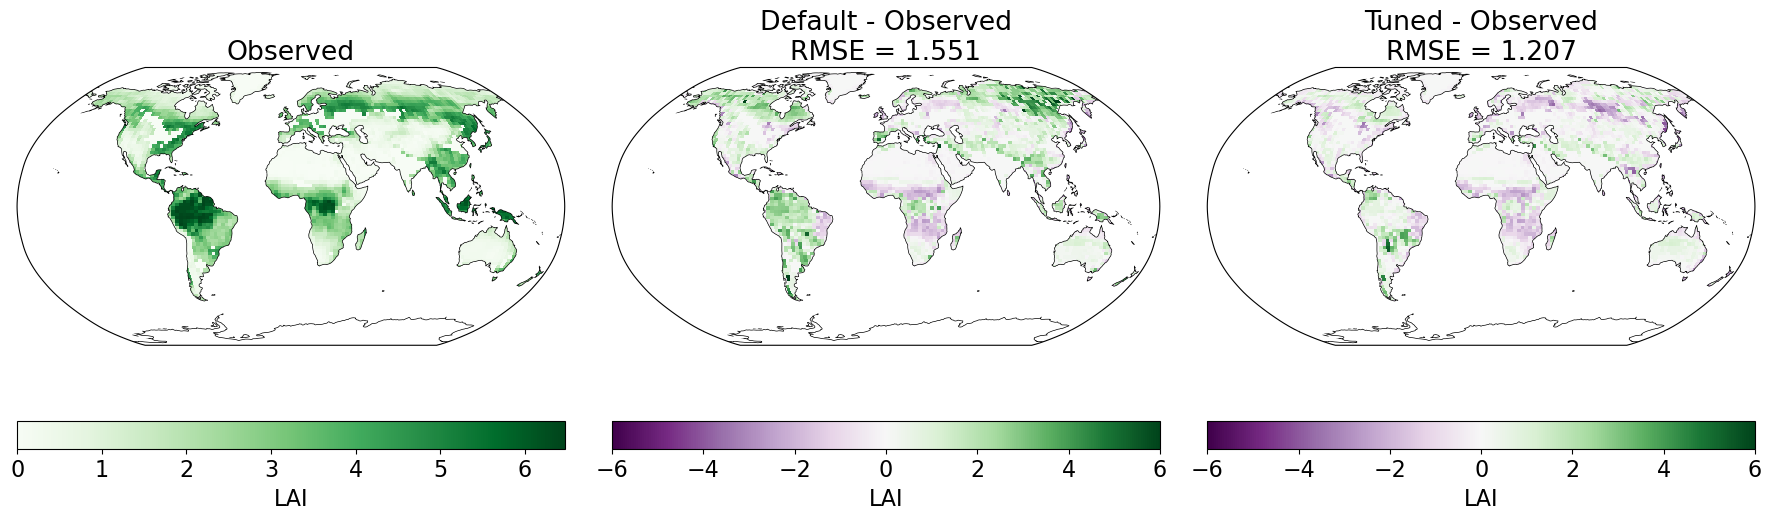

In [26]:
plot_spatial_diagnostics(
    var_name='LAI',
    obs=obs['LAI'],
    default=lai_default,
    tuned=lai.isel(ens=1),
    vmin=-6,
    vmax=6,
    cmap='PRGn',
    savepath='../figs/eval_sg_094_LAI.png'
)


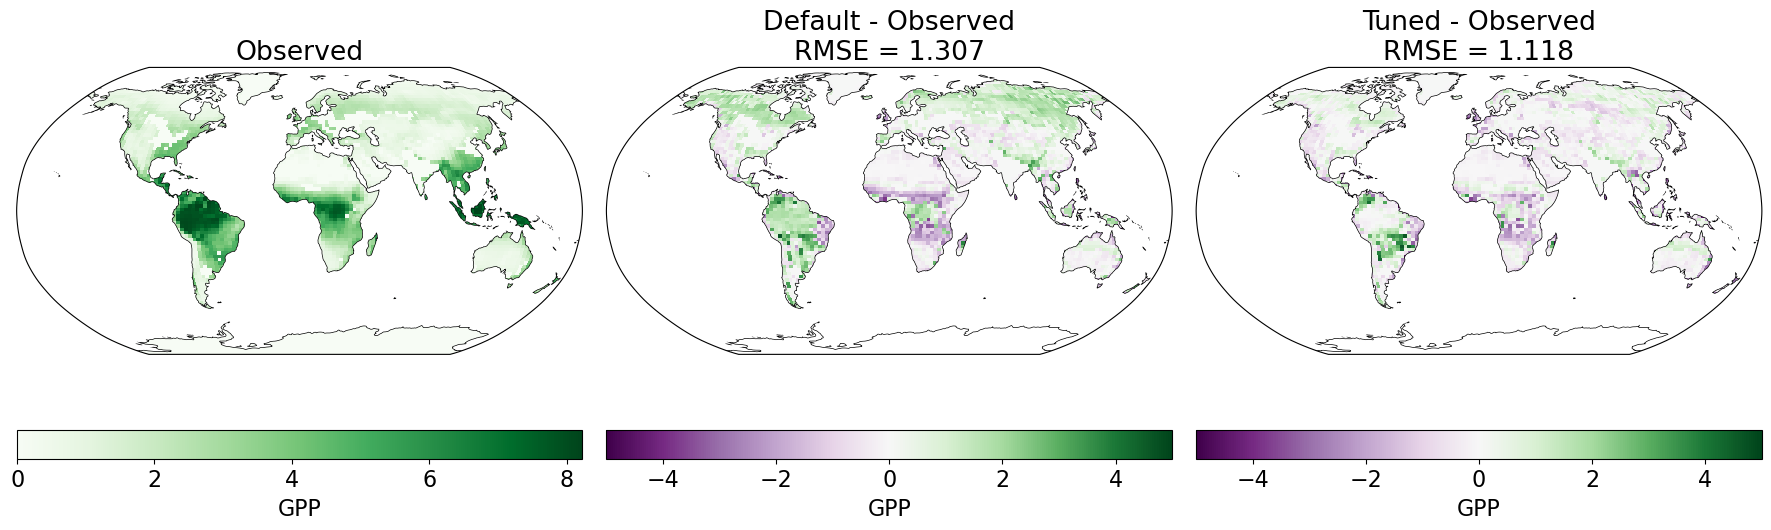

In [27]:
plot_spatial_diagnostics(
    var_name='GPP',
    obs=obs['GPP'],
    default=86400*gpp_default,
    tuned=86400*gpp.isel(ens=1),
    vmin=-5,
    vmax=5,
    cmap='PRGn',
    savepath='../figs/eval_sg_094_GPP.png'
)


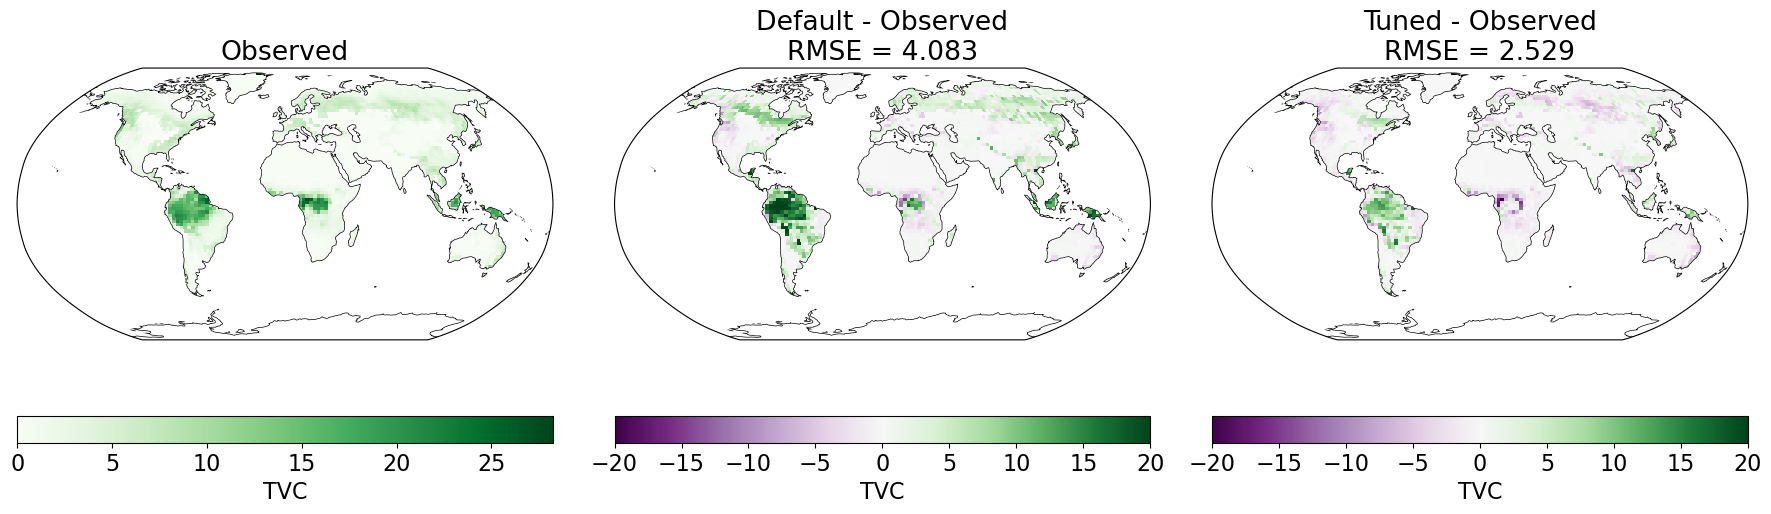

In [10]:
plot_spatial_diagnostics(
    var_name='TVC',
    obs=obs['TOTVEGC'],
    default=(1/1000)*tvc_default,
    tuned=(1/1000)*tvc.isel(ens=1),
    vmin=-20,
    vmax=20,
    cmap='PRGn',
    savepath='../figs/eval_sg_094_TVC.png'
)
